# Voice Activity Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/vad).
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.utils.read.flac('speech/7021-79759-0004.flac')
len(y), sr

(391520, 16000)

### Load WebRTC

```python
def webrtc(
    aggressiveness: int = 3,
    sample_rate: int = 16000,
    minimum_amplitude: int = 100,
):
    """
    Load WebRTC VAD model.

    Parameters
    ----------
    aggressiveness: int, optional (default=3)
        an integer between 0 and 3.
        0 is the least aggressive about filtering out non-speech, 3 is the most aggressive.
    sample_rate: int, optional (default=16000)
        sample rate for samples.
    minimum_amplitude: int, optional (default=100)
        minimum_amplitude to assume a sample is a voice activity. Else, automatically False.

    Returns
    -------
    result : malaya_speech.model.webrtc.WEBRTC class
    """
```

WebRTC developed by Google, reportedly one of the best available, being fast, modern and free. Read more about pywebrtc at https://github.com/wiseman/py-webrtcvad.

In [3]:
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))

### List available deep model

In [4]:
malaya_speech.vad.available_model()

,Size (MB),Accuracy
vggvox-v1,70.8,0.9500
vggvox-v2,31.1,0.9594


### Load deep model

Deep model trained on different noises, augmented noises, procedural noises, overlapped noises and actual voices.

In [3]:
model_v1 = malaya_speech.vad.deep_model(model = 'vggvox-v1')
model_v2 = malaya_speech.vad.deep_model(model = 'vggvox-v2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks. 

For Google WebRTC, we need to split by every 30 ms. For deep learning, we trained on 30 ms, 90 ms and random length less than 300 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames]()

```python
def frames(
    audio,
    frame_duration_ms: int = 30,
    sample_rate: int = 16000,
    append_ending_trail: bool = True,
):
    """
    Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and the sample rate.

    Parameters
    ----------

    audio: np.array / list
    frame_duration_ms: int, optional (default=30)
    sample_rate: int, optional (default=16000)
    append_ending_trail: bool, optional (default=True)
        if True, will append last trail and this last trail might not same length as `frame_duration_ms`.

    Returns
    -------
    result: List[malaya_speech.model.frame.FRAME]
    """
```

In [5]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 1.03 ms, sys: 95 µs, total: 1.12 ms
Wall time: 1.13 ms


In [9]:
%%time

frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 20.6 ms, sys: 1.05 ms, total: 21.7 ms
Wall time: 20.9 ms


In [12]:
%%time

frames_deep_v1 = [(frame, model_v1(malaya_speech.utils.astype.int_to_float(frame))) for frame in frames]

CPU times: user 1min 18s, sys: 11 s, total: 1min 29s
Wall time: 30.3 s


In [13]:
%%time

frames_deep_v2 = [(frame, model_v2(malaya_speech.utils.astype.int_to_float(frame))) for frame in frames]

CPU times: user 57.6 s, sys: 14.3 s, total: 1min 11s
Wall time: 18.2 s


**To speedup, you can do pipeline batching to utilize parallel processing or use GPU or both**.

#### Batching pipeline

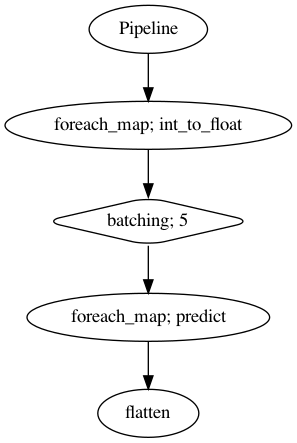

In [14]:
p = Pipeline()
pipeline = (
    p.foreach_map(malaya_speech.utils.astype.int_to_float)
    .batching(5)
    .foreach_map(model_v2.predict)
    .flatten()
)
p.visualize()

In [15]:
%%time

result = p.emit(frames)
result.keys()

CPU times: user 48.7 s, sys: 9.71 s, total: 58.4 s
Wall time: 12.1 s


dict_keys(['int_to_float', 'batching', 'predict', 'flatten'])

In [16]:
frames_deep_v2_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

`frames_deep_v2` == `frames_deep_v2_batch`.

#### get probability

Deep learning model able to calculate probability, simply use `model.predict_proba`, and make sure the input is an array or a list,

In [10]:
%%time

probs = [(frame, model_v2.predict_proba([malaya_speech.utils.astype.int_to_float(frame)])) for frame in frames]
probs[:5]

CPU times: user 53.9 s, sys: 14.3 s, total: 1min 8s
Wall time: 15.5 s


[(<malaya_speech.model.frame.FRAME at 0x110487410>,
  array([[0.72611403, 0.27388594]], dtype=float32)),
 (<malaya_speech.model.frame.FRAME at 0x14a75b210>,
  array([[0.7297444 , 0.27025563]], dtype=float32)),
 (<malaya_speech.model.frame.FRAME at 0x14a75b590>,
  array([[0.73105836, 0.26894164]], dtype=float32)),
 (<malaya_speech.model.frame.FRAME at 0x14a75b910>,
  array([[0.7310581 , 0.26894188]], dtype=float32)),
 (<malaya_speech.model.frame.FRAME at 0x14a75b850>,
  array([[0.73105854, 0.2689415 ]], dtype=float32))]

### VAD Visualization

We can visualize our audio sample to annotate which parts are active speech or not.

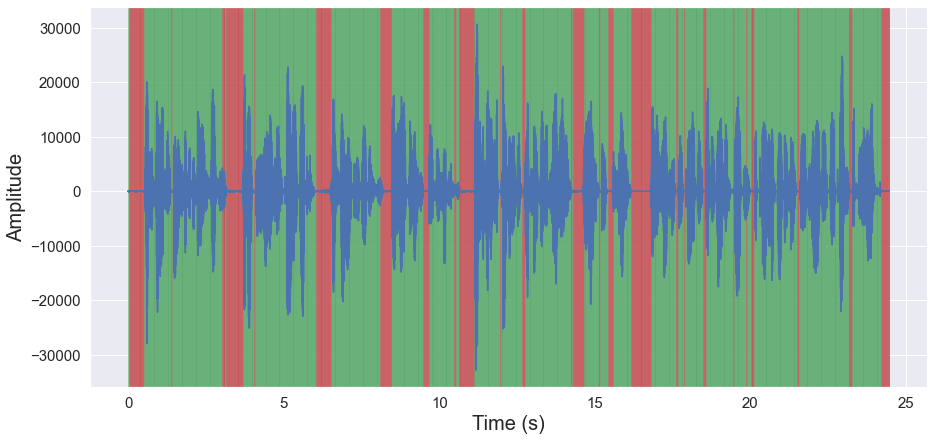

In [17]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

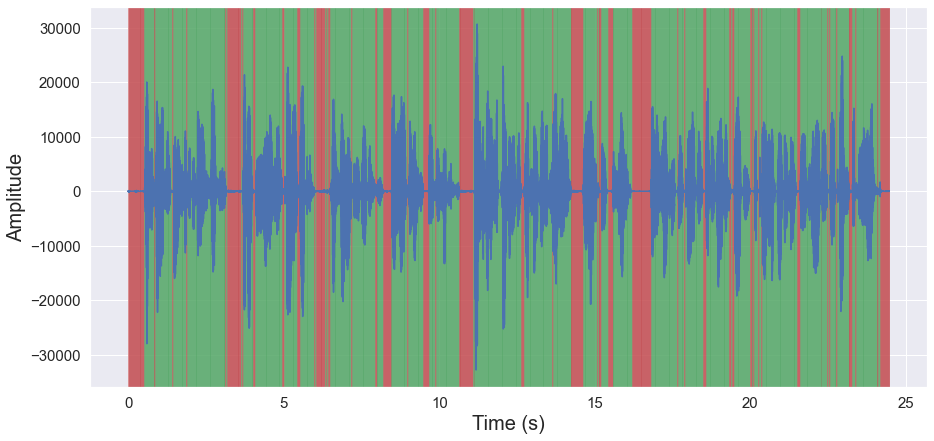

In [18]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

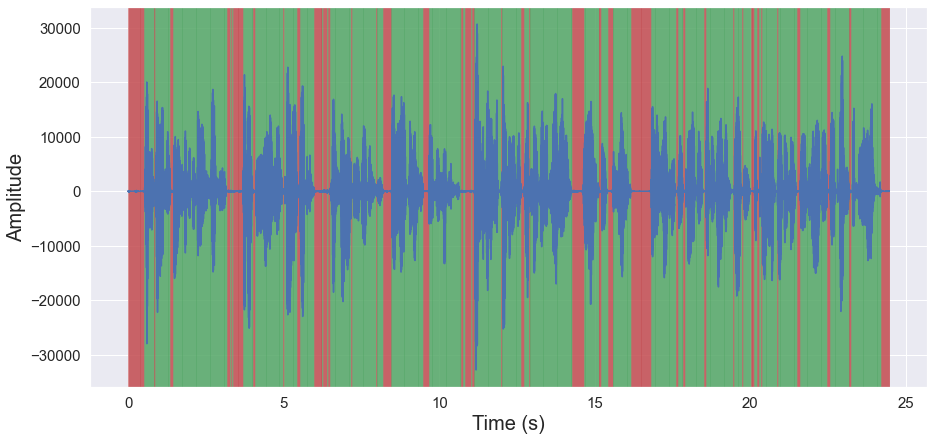

In [20]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v2, sr)

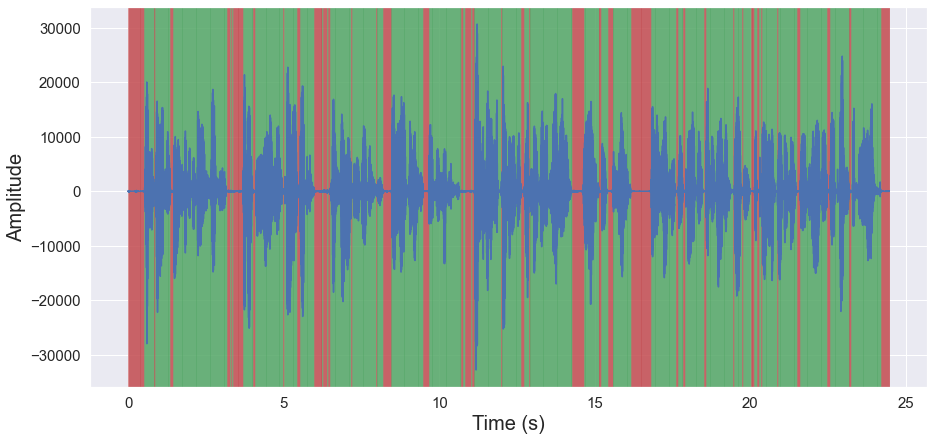

In [21]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v2_batch, sr)

### Groupby VAD

To group small samples into larger samples, use [malaya_speech.utils.group.group_frames]()

In [22]:
grouped_vad = malaya_speech.utils.group.group_frames(frames_webrtc)
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_v2)

In [23]:
len(frames), len(grouped_vad), len(grouped_deep)

(816, 52, 77)

### Harder example

In the real world, not all samples recorded in clean cut studio, full with background noises, music and etc. So those are not the real voice activities. Lets take noise sound,

In [24]:
y, sr = malaya_speech.utils.read.wav('speech/noise/n98.wav')
len(y), sr

(64000, 16000)

In [25]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 7.23 ms, sys: 163 µs, total: 7.39 ms
Wall time: 7.3 ms


In [26]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 5.31 ms, sys: 584 µs, total: 5.89 ms
Wall time: 5.14 ms


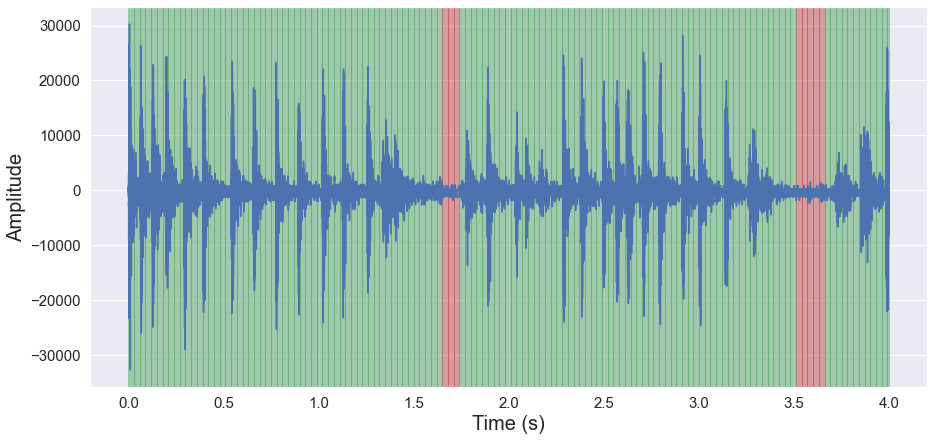

In [27]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [28]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 7.49 s, sys: 1.56 s, total: 9.04 s
Wall time: 1.81 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


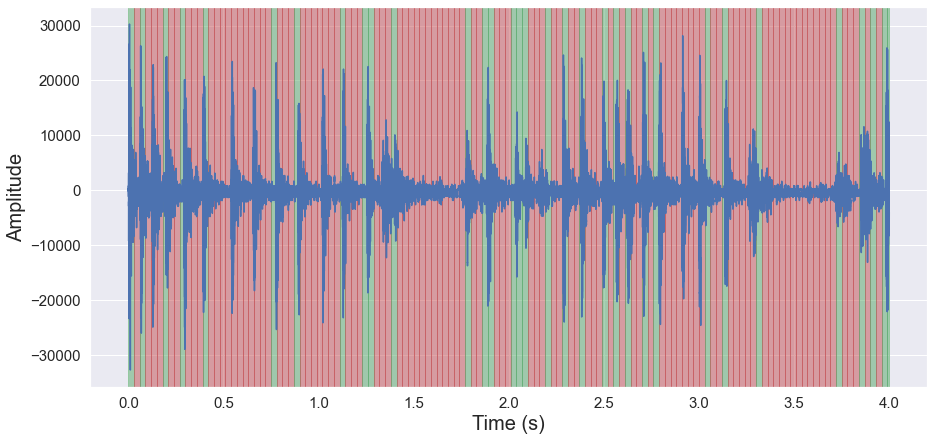

In [29]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

In [30]:
%%time

frames_deep_v1 = [(frame, model_v1(malaya_speech.utils.astype.int_to_float(frame))) for frame in frames]

CPU times: user 13 s, sys: 1.81 s, total: 14.8 s
Wall time: 5.19 s


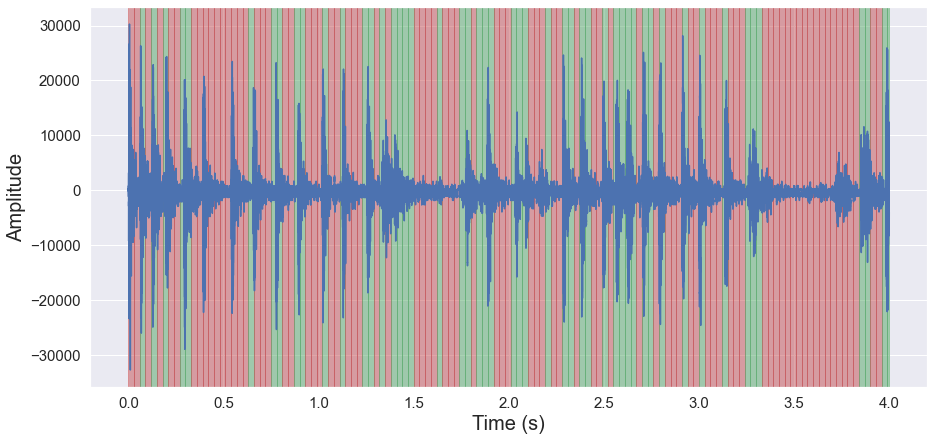

In [31]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_v1, sr)

As you can see, the deep model able to know this sample mostly noises!

In [32]:
y, sr = malaya_speech.utils.read.wav('speech/podcast/2x5%20Ep%2010.wav')
y = y[: sr * 10]
len(y), sr

(160000, 16000)

In [33]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

In [34]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 12.6 ms, sys: 2.43 ms, total: 15 ms
Wall time: 14.1 ms


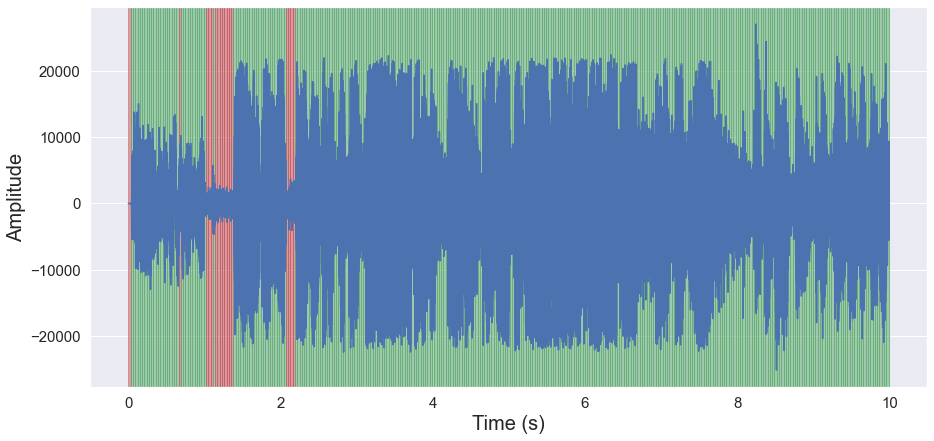

In [35]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [36]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 18.2 s, sys: 3.78 s, total: 22 s
Wall time: 4.48 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


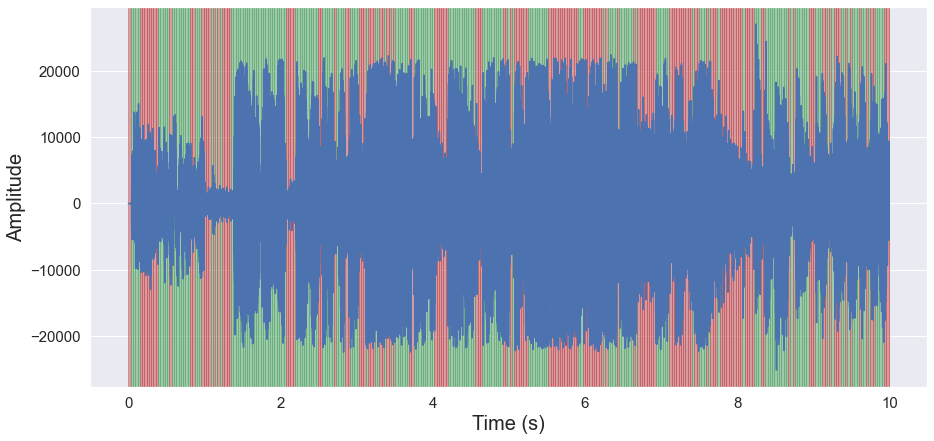

In [37]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

In [38]:
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_batch)

In [39]:
[(no, i[0].duration, i[1]) for no, i in enumerate(grouped_deep[:20])]

[(0, 0.03, False),
 (1, 0.12, True),
 (2, 0.24, False),
 (3, 0.15, True),
 (4, 0.03, False),
 (5, 0.24, True),
 (6, 0.06, False),
 (7, 0.09, True),
 (8, 0.12, False),
 (9, 0.03, True),
 (10, 0.03, False),
 (11, 0.03, True),
 (12, 0.03, False),
 (13, 0.03, True),
 (14, 0.12, False),
 (15, 0.7200000000000004, True),
 (16, 0.12, False),
 (17, 0.30000000000000004, True),
 (18, 0.06, False),
 (19, 0.15, True)]

Now we are going to listen 4, 12, 14, those durations longer than others.

In [40]:
import IPython.display as ipd
ipd.Audio(grouped_deep[4][0].array, rate = sr)

In [41]:
ipd.Audio(grouped_deep[12][0].array, rate = sr)

In [42]:
ipd.Audio(grouped_deep[14][0].array, rate = sr)